In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [15]:
historical = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc')['nao_pattern_djf_em']
historical

<xarray.DataArray 'nao_pattern_djf_em' (lat: 71, lon: 144)> Size: 41kB
[10224 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    nens:       50
    long_name:  NAO spatial pattern (DJF) Ensemble Mean
    pcvar:      40.6%*
    units:      hPa

In [16]:
#Cropping CVDP data to the North Atlantic sector - requires some shifting of 0 of the lat lon coordinate system.
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    ds = ds[pattern]
    
    #finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)
    
    #creating a copy of the data array where the longitudes have been shifted
    ds_shifted = ds.copy()
    ds_shifted.coords['lon'] = new_lon
    
    #Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
    sorted_lon = np.sort(ds_shifted.lon)
    ds_shifted = ds_shifted.sel(lon=sorted_lon)
    
    historical_NAO_EM_shifted = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))

    return historical_NAO_EM_shifted


-0.5042684 0.23261285


/tmp/ipykernel_6213/3966112312.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


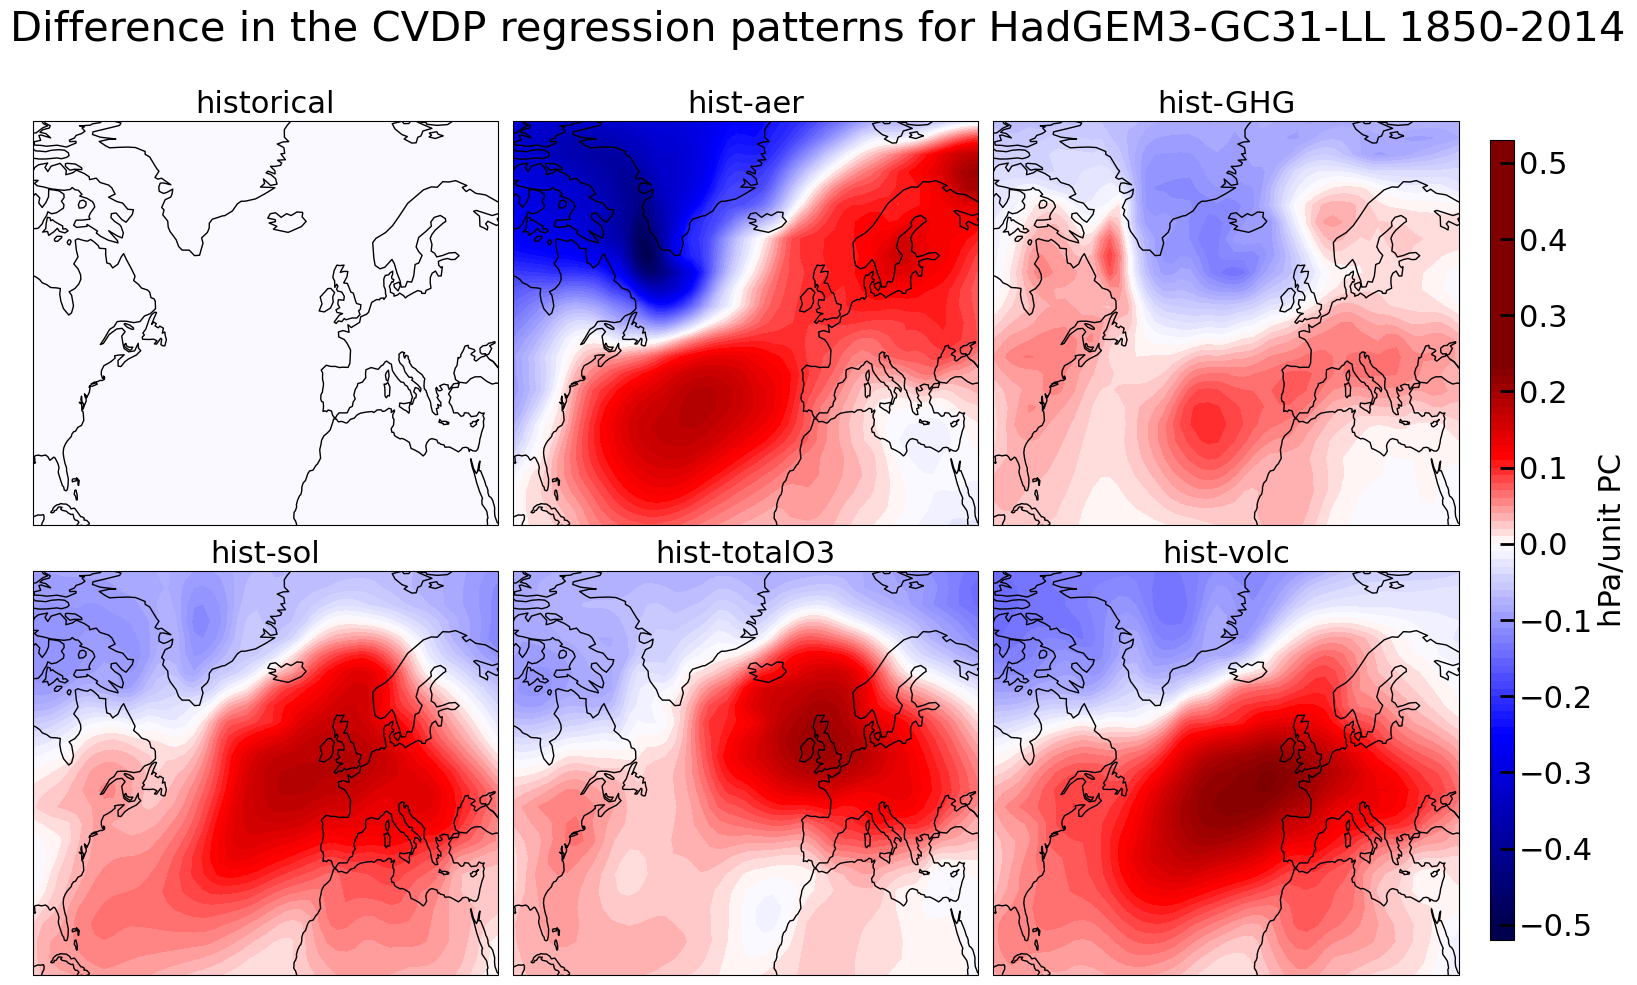

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

cmap = 'seismic'
period = '1850-2014'
experiments = ['historical','hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
model = ['HadGEM3-GC31-LL']

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

lon_range = slice(lon_min,lon_max)
lat_range = slice(lat_min,lat_max)

historical_file = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc'
historical = CVDP_EM_crop_NA_sector(historical_file, ['nao_pattern_djf_em'] )

maximum = 0
minimum = 0

for i, e in enumerate(experiments):
    filename = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/'+e+'/'+e+'_NAO/'+model[0]+'_EM.cvdp_data.nao.1850-2014.nc'
    exp = CVDP_EM_crop_NA_sector(filename, ['nao_pattern_djf_em'])
    diff = historical['nao_pattern_djf_em'] - exp['nao_pattern_djf_em']
    min_val = np.min(diff.values)
    max_val = np.max(diff.values)

    if min_val < minimum:
        minimum = min_val
    if max_val > maximum:
        maximum = max_val

norm = mcolors.TwoSlopeNorm(vmin=minimum, vcenter=0, vmax=maximum)
print(minimum,maximum)
levels = np.arange(-0.52,0.54,0.01)

for i, e in enumerate(experiments):
    filename = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/'+e+'/'+e+'_NAO/'+model[0]+'_EM.cvdp_data.nao.1850-2014.nc'
    exp = CVDP_EM_crop_NA_sector(filename, ['nao_pattern_djf_em'])
    diff = historical['nao_pattern_djf_em'] - exp['nao_pattern_djf_em']
    
    lon = diff['lon'].values
    lat = diff['lat'].values
    
    ax = axes[i]
    contour = ax.contourf(lon, lat, diff.values, cmap=cmap, norm=norm, levels=levels, transform=ccrs.PlateCarree())
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')  
    ax.set_title(e, fontsize=22)

ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])

cbar = fig.colorbar(contour, cax=cax, orientation='vertical', ticks=ticks)
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)


# Add overall labels and title
fig.suptitle(f"Difference in the CVDP regression patterns for {model[0]} {period}", fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/Transfer_talk/NAO_CVDP_regression_patterns_{model[0]}_{period}.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_6213/1336665480.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.1,1,0.95])  # Leave space for colorbar and title


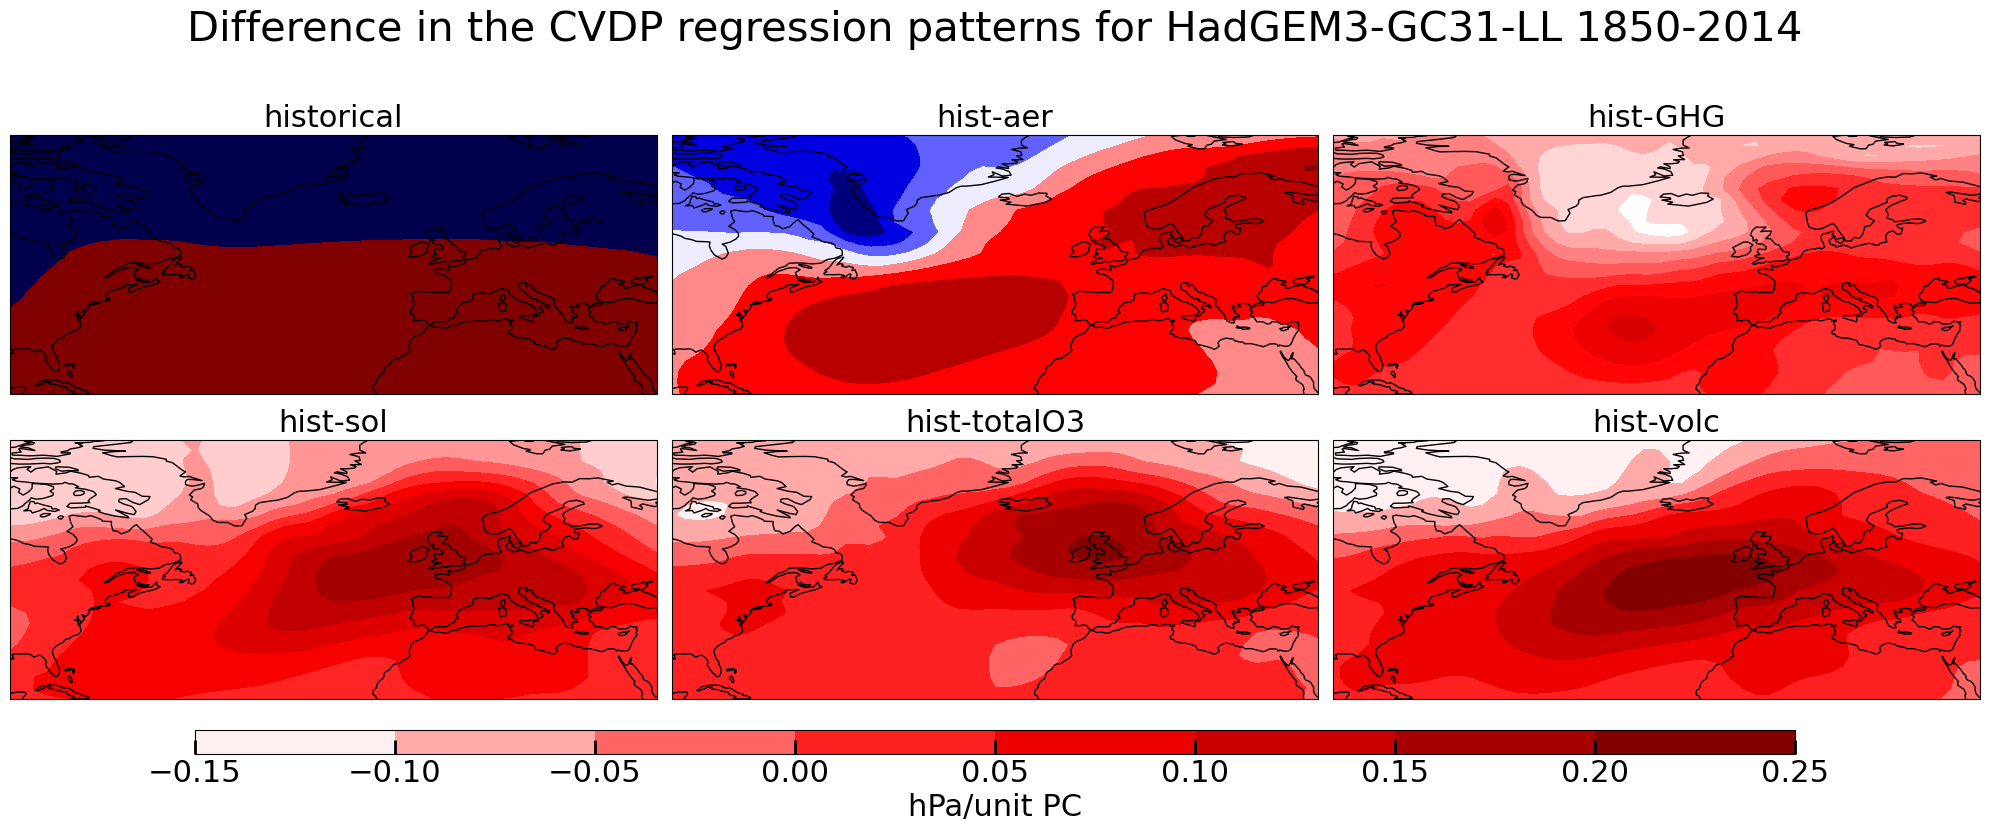

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

cmap = 'seismic'
period = '1850-2014'
experiments = ['historical','hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
model = ['HadGEM3-GC31-LL']

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Load the historical once (reference)
historical_file = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc'
historical = CVDP_EM_crop_NA_sector(historical_file, ['nao_pattern_djf_em'])

# Step 1: Compute global min and max of diff values across all experiments (except 'historical' itself)
all_diffs = []

for e in experiments[1:]:  # skip 'historical' because diff with itself is zero
    filename = f'/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/{e}/{e}_NAO/{model[0]}_EM.cvdp_data.nao.1850-2014.nc'
    exp = CVDP_EM_crop_NA_sector(filename, ['nao_pattern_djf_em'])
    diff = historical['nao_pattern_djf_em'] - exp['nao_pattern_djf_em']
    all_diffs.append(diff.values)

all_diffs = np.array(all_diffs)
vmin = np.min(all_diffs)
vmax = np.max(all_diffs)

norm_all = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Step 2: Plot each difference using the shared norm
for i, e in enumerate(experiments):
    if e == 'historical':
        # Plot the historical data itself (if needed)
        lon = historical['lon'].values
        lat = historical['lat'].values
        data_to_plot = historical['nao_pattern_djf_em'].values
    else:
        filename = f'/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/{e}/{e}_NAO/{model[0]}_EM.cvdp_data.nao.1850-2014.nc'
        exp = CVDP_EM_crop_NA_sector(filename, ['nao_pattern_djf_em'])
        diff = historical['nao_pattern_djf_em'] - exp['nao_pattern_djf_em']
        lon = diff['lon'].values
        lat = diff['lat'].values
        data_to_plot = diff.values

    ax = axes[i]
    cf = ax.contourf(lon, lat, data_to_plot, cmap=cmap, norm=norm_all, transform=ccrs.PlateCarree())
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')
    ax.set_title(e, fontsize=22)

# Step 3: Add a single colorbar for all plots
cax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # Adjust position as needed
cbar = fig.colorbar(cf, cax=cax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)

# Add overall title and layout
fig.suptitle(f"Difference in the CVDP regression patterns for {model[0]} {period}", fontsize=30)
plt.tight_layout(rect=[0,0.1,1,0.95])  # Leave space for colorbar and title
plt.savefig(f'NAO_CVDP_regression_patterns_{model[0]}_{period}.png', bbox_inches='tight')
plt.show()
